# RS电机的数值仿真测试（基于control库）

## 依赖库
```
pip install control
```

## 仿真配置

### 导入仿真包

In [57]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from control import * # 控制库，只做线性和控制律设计
from scipy.integrate import solve_ivp # 数值积分库

## 电机参数

### DM8006

In [116]:
# J = 0.00414          # 转动惯量
J = 0.01         # 转动惯量
d = 0.00             # 粘性摩擦
# F_c = 0.3            # 库仑摩擦
F_c = 0.0            # 库仑摩擦
target_pos = 1.00    # 目标位置

print(f'J = {J}')
print(f'd = {d}')
print(f'F_c = {F_c}')
print(f'target_pos = {target_pos}')

J = 0.01
d = 0.0
F_c = 0.0
target_pos = 1.0


## 二阶系统等价法

### 原理
对于一个标准的二阶系统：

$$
G(s)=\frac{\omega_n^2}{s^2 +2\zeta \omega_n s +\omega_n^2}
$$

其中：
* $\omega_n$：自然频率（rad/s）
* $\zeta$：阻尼比

<div align="center">
    <img src="https://cdn.jsdelivr.net/gh/zhaobohao-byte/img@main/image-20260122190302-z45igzw.png" width="400">
</div>

这在机械系统里，可以类比成：

$$
J\ddot{\theta}+B\dot{\theta}+K\theta=0
$$

其中：
* $J$：等效惯量（ARMATURE）
* $B$：阻尼系数
* $K$：刚度


根据目标响应特性：

* 目标自然频率：10 $Hz$  $\omega_n=10\times 2\pi$
* 目标阻尼比：$\zeta=2.0$

把这些性能指标映射到等效刚度和阻尼上。

---
### 计算公式

1. 刚度

$$K = J\omega_n^2$$

2. 阻尼系数

$$ B = 2\zeta J\omega_n$$

In [118]:
ARMATURE = J
NATURAL_FREQ = 10   # 10Hz
DAMPING_RATIO = 2.0
STIFFNESS = ARMATURE * (NATURAL_FREQ * 2.0 * 3.1415926535) **2
DAMPING = 2.0 * DAMPING_RATIO * ARMATURE * (NATURAL_FREQ * 2.0 * 3.1415926535)
Kp = STIFFNESS
Kd = DAMPING
print(f'STIFFNESS_5020 = {STIFFNESS}')
print(f'DAMPING_5020 = {DAMPING}')

STIFFNESS_5020 = 39.478417602100684
DAMPING_5020 = 2.5132741228


### 仿真运行(无电流环特性)

sol =   message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.003e-04 ...  9.995e-01  1.000e+00]
        y: [[ 0.000e+00  4.919e-05 ...  1.000e+00  1.000e+00]
            [ 0.000e+00  1.963e-01 ...  2.893e-05  2.809e-05]]
      sol: None
 t_events: None
 y_events: None
     nfev: 320
     njev: 0
      nlu: 0


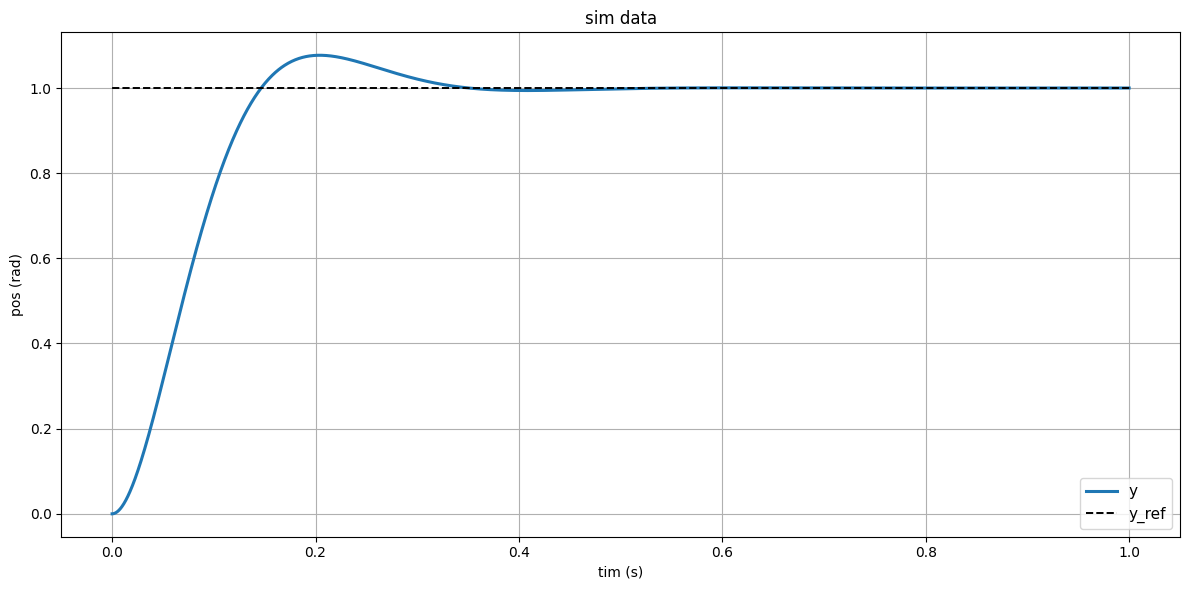

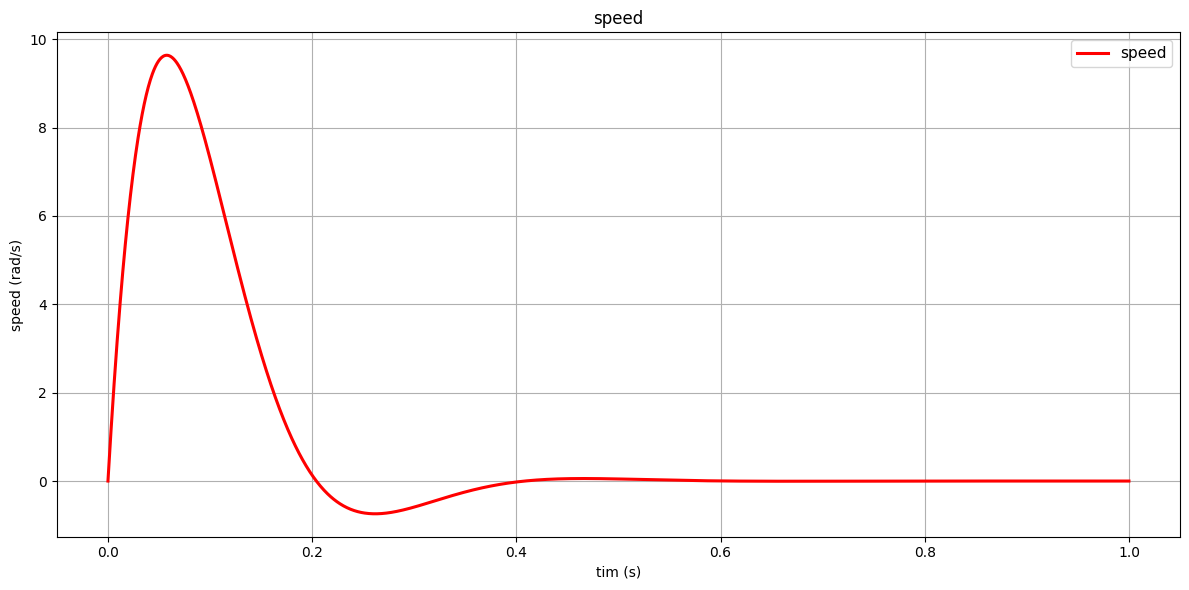

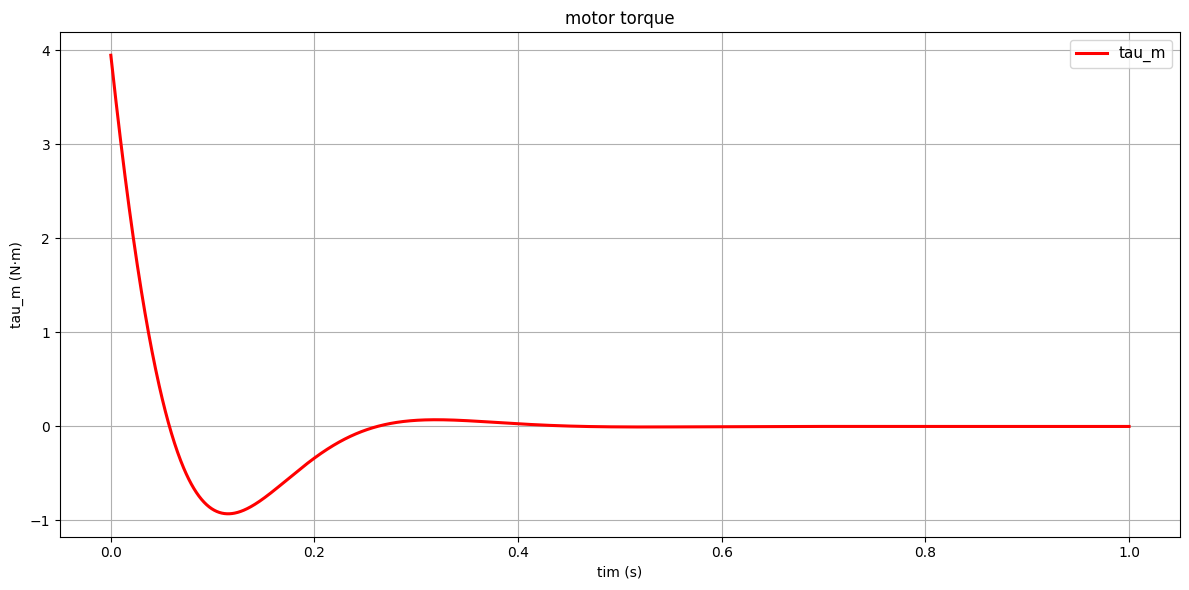

In [117]:
############# 无电流环特性情况  ################
def dynamics(t, state):
    q, dq = state
    e = target_pos - q
    
    
    friction_real = F_c * np.sign(dq) # 摩擦前馈
    tau_cmd = Kp * e - Kd * dq
    ddq = (tau_cmd - friction_real - d * dq) / J
    
    return [dq, ddq]

t_span = (0, 1.0)
t_eval = np.linspace(0, 1.0, 2000)

sol = solve_ivp(dynamics, t_span, [0.0, 0.0], t_eval=t_eval, method='RK45', rtol=1e-6)
print(f'sol = {sol}')   

# 计算 tau_m (电机扭矩)
q_values = sol.y[0]
dq_values = sol.y[1]
e_values = target_pos - q_values
tau_m = Kp * e_values - Kd * dq_values

# 绘制位置图
plt.figure(figsize=(12, 6))

plt.plot(sol.t, sol.y[0], label='y', lw=2.2)
plt.plot(t_eval, np.full_like(t_eval, target_pos), '--k', lw=1.4, label='y_ref')

plt.grid(True)
plt.legend(fontsize=11)
plt.xlabel('tim (s)')
plt.ylabel('pos (rad)')
plt.title(f'sim data')
plt.tight_layout()
plt.show()

# 绘制 speed 图
plt.figure(figsize=(12, 6))

plt.plot(sol.t, dq_values, label='speed', lw=2.2, color='r')

plt.grid(True)
plt.legend(fontsize=11)
plt.xlabel('tim (s)')
plt.ylabel('speed (rad/s)')
plt.title(f'speed')
plt.tight_layout()
plt.show()

# 绘制 tau_m 图
plt.figure(figsize=(12, 6))

plt.plot(sol.t, tau_m, label='tau_m', lw=2.2, color='r')

plt.grid(True)
plt.legend(fontsize=11)
plt.xlabel('tim (s)')
plt.ylabel('tau_m (N·m)')
plt.title(f'motor torque')
plt.tight_layout()
plt.show()


### 仿真运行(带电流环特性1kHz)

sol =   message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.003e-04 ...  9.995e-01  1.000e+00]
        y: [[ 0.000e+00  2.712e-04 ...  1.000e+00  1.000e+00]
            [ 0.000e+00  1.339e+00 ...  9.021e-07  8.981e-07]
            [ 0.000e+00  3.565e+01 ... -5.792e-07 -7.922e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 12884
     njev: 0
      nlu: 0


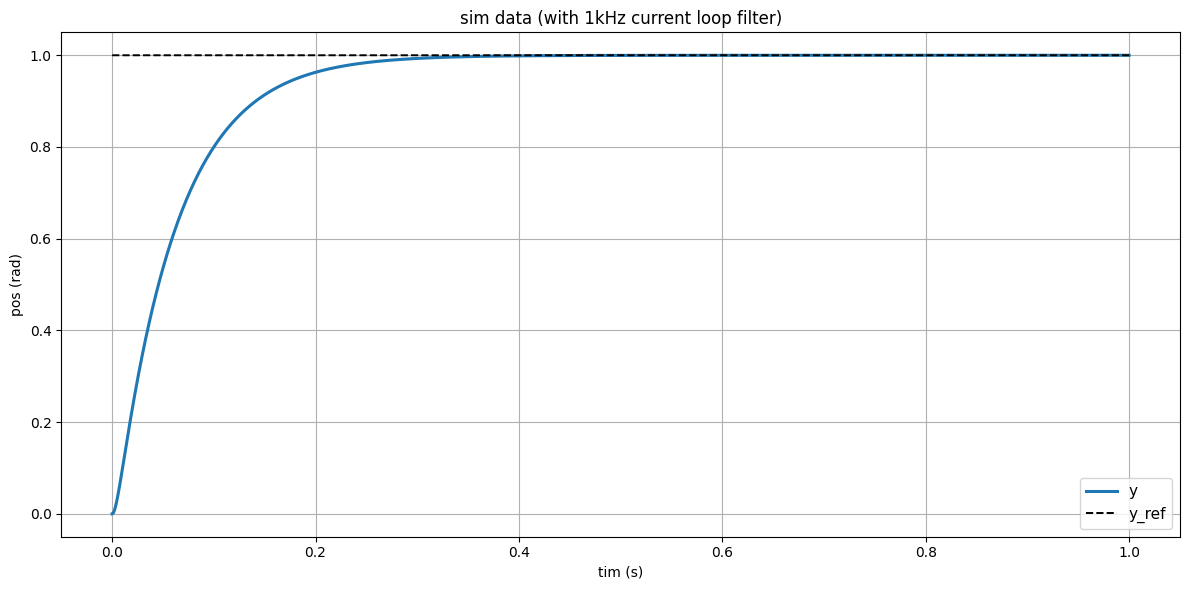

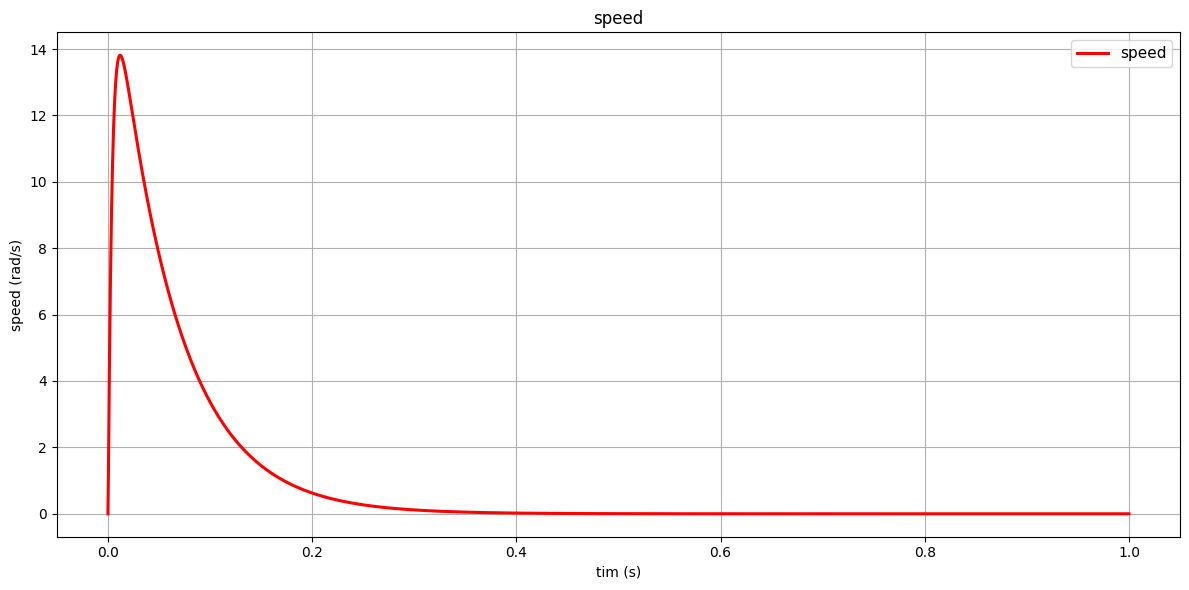

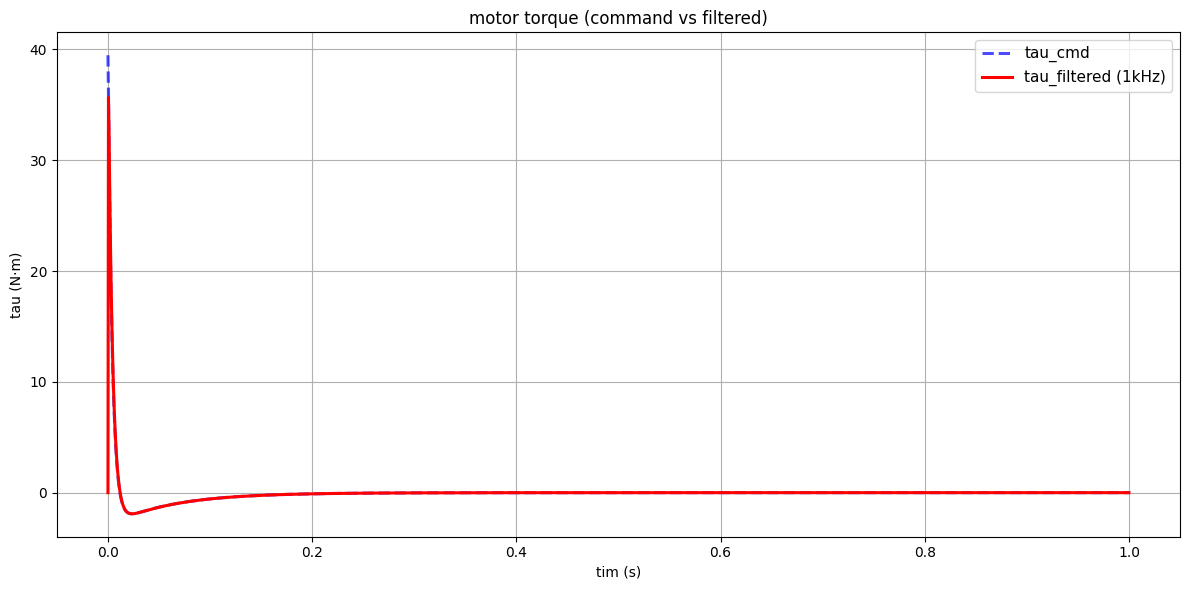

In [119]:
############# 带电流环特性情况  ################
# 1kHz电流环
f_cutoff = 1000.0  
tau_filter = 1.0 / (2.0 * np.pi * f_cutoff) 

def dynamics(t, state):
    q, dq, tau_filtered = state  # 状态: 位置, 速度, 滤波后的扭矩
    e = target_pos - q
    
    tau_cmd = Kp * e - Kd * dq
    dtau_filtered_dt = (tau_cmd - tau_filtered) / tau_filter
    
    friction_real = F_c * np.sign(dq)  # 摩擦前馈
    ddq = (tau_filtered - friction_real - d * dq) / J
    
    return [dq, ddq, dtau_filtered_dt]

t_span = (0, 1.0)
t_eval = np.linspace(0, 1.0, 2000)

initial_state = [0.0, 0.0, 0.0]

sol = solve_ivp(dynamics, t_span, initial_state, t_eval=t_eval, method='RK45', rtol=1e-6)
print(f'sol = {sol}')   

q_values = sol.y[0]
dq_values = sol.y[1]
tau_filtered_values = sol.y[2]  

e_values = target_pos - q_values
tau_cmd = Kp * e_values - Kd * dq_values

plt.figure(figsize=(12, 6))

plt.plot(sol.t, sol.y[0], label='y', lw=2.2)
plt.plot(t_eval, np.full_like(t_eval, target_pos), '--k', lw=1.4, label='y_ref')

plt.grid(True)
plt.legend(fontsize=11)
plt.xlabel('tim (s)')
plt.ylabel('pos (rad)')
plt.title(f'sim data (with 1kHz current loop filter)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.plot(sol.t, dq_values, label='speed', lw=2.2, color='r')

plt.grid(True)
plt.legend(fontsize=11)
plt.xlabel('tim (s)')
plt.ylabel('speed (rad/s)')
plt.title(f'speed')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.plot(sol.t, tau_cmd, label='tau_cmd', lw=2.2, color='b', linestyle='--', alpha=0.7)
plt.plot(sol.t, tau_filtered_values, label='tau_filtered (1kHz)', lw=2.2, color='r')

plt.grid(True)
plt.legend(fontsize=11)
plt.xlabel('tim (s)')
plt.ylabel('tau (N·m)')
plt.title(f'motor torque (command vs filtered)')
plt.tight_layout()
plt.show()


## LQR时域法

LQR求控制律

- 原动力系统为
$$\begin{equation}
I\ddot{\theta}(t) = \tau(t)
\end{equation}$$

- 定义状态变量：

$$\begin{equation}
\mathbf{x}(t) =
\begin{bmatrix}
\theta(t) \\
\dot{\theta}(t)
\end{bmatrix}
\end{equation}$$

- 状态空间方程：

$$\begin{equation}
\dot{\mathbf{x}} =
\begin{bmatrix}
0 & 1 \\
0 & 0
\end{bmatrix}
\mathbf{x}
+
\begin{bmatrix}
0 \\
\frac{1}{I}
\end{bmatrix}
\tau
\end{equation}$$

- LQR的损失方程为：

$$\begin{equation}
J = \int_0^\infty
\left(
\mathbf{x}^\mathsf{T} Q \mathbf{x}
+
\tau^\mathsf{T} R \tau
\right) dt
\end{equation}$$

- 最优控制律为：

$$\begin{equation}
\tau = -K_p\theta(t) + K_d \dot{\theta}(t)
\end{equation}$$
这其实就是PD控制律。

### 控制参数求解

In [ ]:
## LQR求Kp和Kd
A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1/J]])
C = np.array([[1, 0]])  
# 权重矩阵
Q = np.diag([300, 1])           
R = np.array([[1]])             


In [ ]:

# 创建状态空间对象
sys = ss(A, B, C, 0)

K, S, E = lqr(sys, Q, R)
Kp_LQR = K[0, 0]  
Kd_LQR = K[0, 1]   

print(f"Kp (位置)         = {Kp_LQR:.6f}")
print(f"Kd (速度/角速度)   = {Kd_LQR:.6f} ")
print(f"闭环极点：{E}")

### 仿真

In [ ]:
def dynamics(t, state):
    q, dq = state
    e = target_pos - q
    
    # 摩擦前馈
    friction_real = F_c * np.sign(dq)
    tau_cmd = Kp_LQR * e - Kd_LQR * dq
    ddq = (tau_cmd - friction_real) / J
    
    return [dq, ddq]

t_span = (0, 1.0)
t_eval = np.linspace(0, 1.0, 2000)

sol = solve_ivp(dynamics, t_span, [0.0, 0.0], t_eval=t_eval, method='RK45', rtol=1e-6)
print(f'sol = {sol}')  

### 绘图

In [ ]:

plt.figure(figsize=(12, 6))

plt.plot(sol.t, sol.y[0], label='y', lw=2.2)
plt.plot(t_eval, np.full_like(t_eval, target_pos), '--k', lw=1.4, label='y_ref')

plt.grid(True)
plt.legend(fontsize=11)
plt.xlabel('tim (s)')
plt.ylabel('pos (rad)')
plt.title(f'sim data')
plt.tight_layout()
plt.show()